# Laboratorio 3 Malware detection
## Security Data Science
### Universidad del valle de Guatemala

Abner Ivan Garcia - 21285
Oscar Esteba Donis - 21610

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
import tensorflow as tf

# Cargar el conjunto de datos
df = pd.read_csv("malware-dataset.csv", header=0)
df.head()

,sha256,labels,0,1,2,3,4,5,6,7,...,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176
0,5c18291c481a192ed5003084dab2d8a117fd3736359218...,0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4683faf3da550ffb594cf5513c4cbb34f64df85f27fd1c...,0,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9a0aea1c7290031d7c3429d0e921f107282cc6eab854ee...,0,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e0f3e4d5f50afd9c31e51dd9941c5a52d57c7c524f5d11...,0,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ec2b6d29992f13e74015ff0b129150b4afae15c593e4b7...,0,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


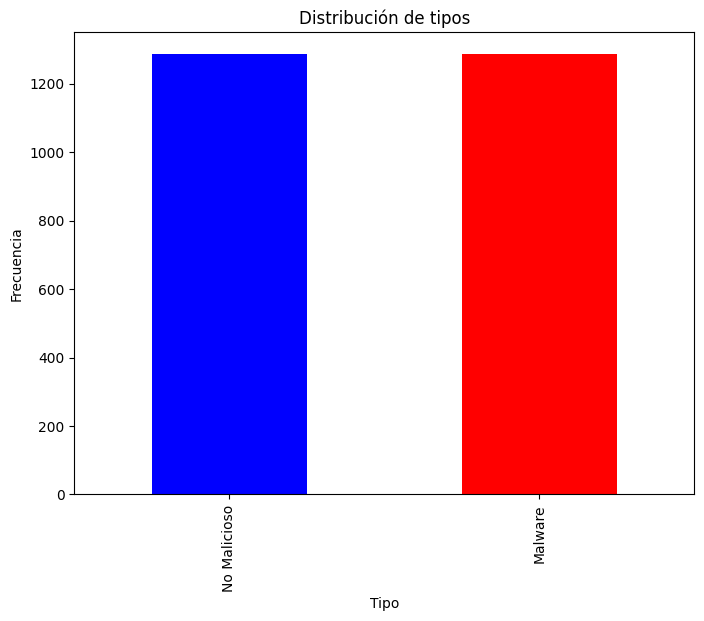

In [3]:
# creando la gráfica de distribucion de tipos 
plt.figure(figsize=(8, 6))
df['labels'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Distribución de tipos')
plt.xlabel('Tipo')
plt.ylabel('Frecuencia')
plt.gca().set_xticklabels(['No Malicioso', 'Malware'])
plt.show()

## Grafica de las llamadas a las APIs más comunes

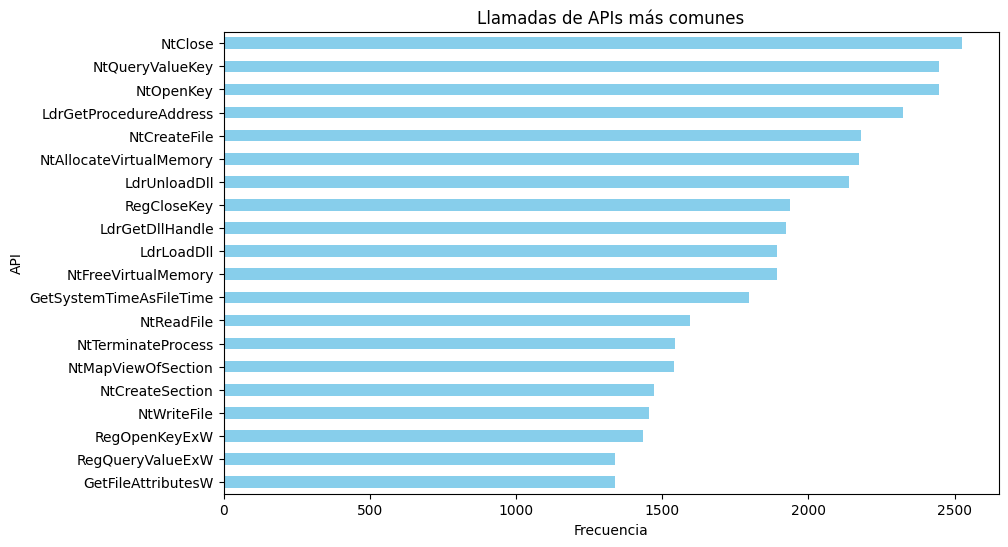

In [4]:
# llamadas a las APIs más comunes
llamadas_apis = df.drop(['sha256', 'labels'], axis=1).stack().value_counts() # contar las llamadas a las APIs
top_calls = llamadas_apis.head(20) # top 20 

plt.figure(figsize=(10, 6)) # graficar
top_calls.plot(kind='barh', color='skyblue') # graficar en barras horizontales
plt.title('Llamadas de APIs más comunes') # título de la gráfica
plt.xlabel('Frecuencia') # etiqueta en x 
plt.ylabel('API') # etiqueta en y 
plt.gca().invert_yaxis() # invertir el eje y para que aparezca la API más común en la parte superior
plt.show()

## Dividir datos en caracteristicas

In [5]:
le = LabelEncoder() # codificar las etiquetas
df = df.apply(le.fit_transform) # aplicar la codificación a las etiquetas del conjunto de datos

# Dividir el conjunto de datos en características y etiquetas
X = df.drop(['labels', 'sha256'], axis=1) # características 
y = df['labels'] # etiquetas

X

,0,1,2,3,4,5,6,7,8,9,...,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176
0,26,2,65,52,29,31,44,37,63,31,...,1,1,1,1,1,1,1,1,1,1
1,35,19,65,9,78,92,46,1,85,98,...,1,1,1,1,1,1,1,1,1,1
2,14,7,26,35,34,77,94,22,105,73,...,1,1,1,1,1,1,1,1,1,1
3,39,31,35,95,66,43,85,54,62,48,...,1,1,1,1,1,1,1,1,1,1
4,26,23,60,94,104,83,56,53,81,48,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,3,13,1,77,44,13,83,2,43,85,...,1,1,1,1,1,1,1,1,1,1
2566,31,62,39,68,93,83,78,93,71,66,...,1,1,1,1,1,1,1,1,1,1
2567,10,51,1,77,44,31,100,79,85,25,...,1,1,1,1,1,1,1,1,1,1
2568,28,30,90,21,33,44,45,70,85,51,...,1,1,1,1,1,1,1,1,1,1


In [6]:
print(X.shape)
print(y.shape)

(2570, 175)
(2570,)


In [7]:
print(y.value_counts())


labels
0    1285
1    1285
Name: count, dtype: int64


In [8]:
print(y)

0       0
1       0
2       0
3       0
4       0
       ..
2565    1
2566    1
2567    1
2568    1
2569    1
Name: labels, Length: 2570, dtype: int64


Estandarizamos todas las medidas a una unidad única

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Creamos los conjuntos de entrenamiento y prueba para nuestros modelos

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

## Primer Modelo

In [11]:
def getPrimerModel(x_data, y_data):
    # Creamos nuestro modelo con una 6 capas
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(x_data.shape[1],)),  # Capa para entrada de datos
        tf.keras.layers.Dense(256, activation='elu'),                                   # Utilizamos elu para evitar el dead neuron problem y poder mejorar el aprendizaje de nuestro modelo.
        tf.keras.layers.BatchNormalization(),                                           # Capa de normatización de lote
        tf.keras.layers.Dense(64, activation='elu'),                                    
        tf.keras.layers.BatchNormalization(),                                           # Capa de normatización de lote
        tf.keras.layers.Dense(32, activation='elu'),
        tf.keras.layers.BatchNormalization(),                                           # Capa de normatización de lote
        tf.keras.layers.Dense(16, activation='leaky_relu'),                             # Capa para eliminar valores negativos
        tf.keras.layers.BatchNormalization(),                                           # Capa de normatización de lote
        tf.keras.layers.Dense(1, activation='sigmoid')                                  # Capa de clasificación, utilizando función sigmoid para clasificación de 2 tipos
    ])

    # Compilamos nuestro modelo con optimizador Adam, binary_crossentropy (para un clasificador de solamento dos valores) y utilizamos el accuracy
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenamos el modelo con 15 epocas, por lotes de 32 elementos y con un conjunto de validación del 10%
    model.fit(x_data, y_data, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

    return model

Evaluamos el modelo con el conjunto de prueba, separamos las predicciones entre: mayor a 0.5 es malicioso y menor a 0.5 no es malicioso

In [12]:
def getModelPredictions(model, test_data):
    y_pred = model.predict(test_data)
    y_pred_results = (y_pred > 0.5).astype(int)

    return y_pred, y_pred_results

Calculamos las métricas de accuracy, precision, recall y la curva ROC para mejorar el reconocimiento

In [13]:
model = getPrimerModel(X_train, y_train)

y_predictions, y_predictions_results = getModelPredictions(model, X_test)

accuracy = accuracy_score(y_test, y_predictions_results)
precision = precision_score(y_test, y_predictions_results)
recall = recall_score(y_test, y_predictions_results)
roc_auc = roc_auc_score(y_test, y_predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("Puntajes ROC y AUC:", roc_auc)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.8586251621271076
Precision: 0.9122807017543859
Recall: 0.7979539641943734
Puntajes ROC y AUC: 0.9219645981962579


## Validación Cruzada (Primer Modelo)

Definimos las variables donde vamos a estar almacenando nuestros puntajes

In [14]:
accuracy_scores = []
precision_scores = []
recall_scores = []
roc_auc_scores = []

# Cantidad de splits que vamos a dividir nuestro dataset
k = 10

Separamos la data en splits iguales, usando la función StratifiedKFold para poder asegurarnos de que los splits que generemos contengan la misma proporción de emails maliciosos

In [15]:
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

Iteramos por cada uno de los splits generados para poder 

In [16]:
for train_index, test_index in skf.split(X_scaled, y):
    X_train_split, X_test_split = X_scaled[train_index], X_scaled[test_index]
    y_train_split, y_test_split = y[train_index], y[test_index]

    model = getPrimerModel(X_train_split, y_train_split)

    y_predictions_split, y_predictions_split_results = getModelPredictions(model, X_test_split)

    accuracy_scores.append(accuracy_score(y_test_split, y_predictions_split_results))
    precision_scores.append(precision_score(y_test_split, y_predictions_split_results))
    recall_scores.append(recall_score(y_test_split, y_predictions_split_results))
    roc_auc_scores.append(roc_auc_score(y_test_split, y_predictions_split))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Calculamos algunas estádisticas de las métricas del modelos de la validación cruzada

In [17]:
accuracy_mean = np.mean(accuracy_scores)
precision_mean = np.mean(precision_scores)
recall_mean = np.mean(recall_scores)
roc_auc_mean = np.mean(roc_auc_scores)

accuracy_median = np.median(accuracy_scores)
precision_median = np.median(precision_scores)
recall_median = np.median(recall_scores)
roc_auc_median = np.median(roc_auc_scores)

accuracy_min = np.min(accuracy_scores)
precision_min = np.min(precision_scores)
recall_min = np.min(recall_scores)
roc_auc_min = np.min(roc_auc_scores)

accuracy_max = np.max(accuracy_scores)
precision_max = np.max(precision_scores)
recall_max = np.max(recall_scores)
roc_auc_max = np.max(roc_auc_scores)

accuracy_std = np.std(accuracy_scores)
precision_std = np.std(precision_scores)
recall_std = np.std(recall_scores)
roc_auc_std = np.std(roc_auc_scores)

print("Accuracy:")
print("Media de Accuracy:", accuracy_mean)
print("Mediana de Accuracy:", accuracy_median)
print("Máximo de Accuracy:", accuracy_max)
print("Mínimo de Accuracy:", accuracy_min)
print("Desviación Estandar de Accuracy:", accuracy_std)

print("\nPrecision:")
print("Media de Precision:", precision_mean)
print("Mediana de Precision:", precision_median)
print("Máximo de Precision:", precision_max)
print("Mínimo de Precision:", precision_min)
print("Desviación Estandar de Precision:", precision_std)

print("\nRecall:")
print("Media de Recall:", recall_mean)
print("Mediana de Recall:", recall_median)
print("Máximo de Recall:", recall_max)
print("Mínimo de Recall:", recall_min)
print("Desviación Estandar de Recall:", recall_std)

print("\nROC AUC:")
print("Media de ROC AUC:", roc_auc_mean)
print("Mediana de ROC AUC:", roc_auc_median)
print("Máximo de ROC AUC:", roc_auc_max)
print("Mínimo de ROC AUC:", roc_auc_min)
print("Desviación Estandar de ROC AUC:", roc_auc_std)

Accuracy:
Media de Accuracy: 0.885603112840467
Mediana de Accuracy: 0.8852140077821011
Máximo de Accuracy: 0.9182879377431906
Mínimo de Accuracy: 0.8560311284046692
Desviación Estandar de Accuracy: 0.01923611999114128

Precision:
Media de Precision: 0.9371283589451265
Mediana de Precision: 0.938425925925926
Máximo de Precision: 0.9719626168224299
Mínimo de Precision: 0.912
Desviación Estandar de Precision: 0.0175432538439992

Recall:
Media de Recall: 0.827234738372093
Mediana de Recall: 0.8248546511627908
Máximo de Recall: 0.8837209302325582
Mínimo de Recall: 0.7596899224806202
Desviación Estandar de Recall: 0.04152709670074136

ROC AUC:
Media de ROC AUC: 0.9381237887596898
Mediana de ROC AUC: 0.9395288275193798
Máximo de ROC AUC: 0.9627543604651163
Mínimo de ROC AUC: 0.8979832848837209
Desviación Estandar de ROC AUC: 0.02106169454448109


## Segundo Modelo (Gemini)

Instalamos la librería de google-generativeai

In [18]:
%pip install -U -q google-generativeai

Note: you may need to restart the kernel to use updated packages.


Importamos las librería necesarias para nuestro modelo

In [19]:
import re
import tqdm
import keras
import numpy as np
import pandas as pd
import dotenv
import os

import google.generativeai as genai

import seaborn as sns
import matplotlib.pyplot as plt

from keras import layers
from matplotlib.ticker import MaxNLocator
from sklearn.datasets import fetch_20newsgroups
import sklearn.metrics as skmetrics

Configuramos el acceso con nuestra llave de Google API, para poder utilizar los servicios de AI de Google

In [20]:
dotenv.load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
# client = genai.Client(api_key=GOOGLE_API_KEY)
genai.configure(api_key=GOOGLE_API_KEY)

In [21]:
for m in genai.list_models():
  if 'embedContent' in m.supported_generation_methods:
    print(m.name)

models/embedding-001
models/text-embedding-004


Extraemos los datos otra vez para realizar el preprocesamiento

In [22]:
mails = pd.read_csv("malware-dataset.csv", header=0)
mails.head()

,sha256,labels,0,1,2,3,4,5,6,7,...,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176
0,5c18291c481a192ed5003084dab2d8a117fd3736359218...,0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4683faf3da550ffb594cf5513c4cbb34f64df85f27fd1c...,0,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9a0aea1c7290031d7c3429d0e921f107282cc6eab854ee...,0,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e0f3e4d5f50afd9c31e51dd9941c5a52d57c7c524f5d11...,0,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ec2b6d29992f13e74015ff0b129150b4afae15c593e4b7...,0,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Separamos nuestra variable objetivo de las variables predictoras

In [23]:
X_data = mails.drop(['labels', 'sha256'], axis=1)
y_data = mails['labels']

X_data

,0,1,2,3,4,5,6,7,8,9,...,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176
0,LdrUnloadDll,CoUninitialize,NtQueryKey,NtDuplicateObject,GetShortPathNameW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtClose,GetFileVersionInfoSizeW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NtOpenMutant,GetForegroundWindow,NtQueryKey,DrawTextExW,NtSetInformationFile,RegQueryValueExA,LdrGetProcedureAddress,CoUninitialize,NtQueryValueKey,RegCloseKey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,GetForegroundWindow,DrawTextExW,GetSystemInfo,IsDebuggerPresent,GetSystemWindowsDirectoryW,NtQueryValueKey,RegCloseKey,GetFileAttributesW,RegQueryValueExW,NtMapViewOfSection,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NtQueryValueKey,LdrUnloadDll,GlobalMemoryStatus,WriteConsoleA,NtOpenKey,LdrGetProcedureAddress,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,LdrGetDllHandle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LdrUnloadDll,GetSystemTimeAsFileTime,NtOpenKey,WSAStartup,SetUnhandledExceptionFilter,NtTerminateProcess,NtClose,NtAllocateVirtualMemory,NtQueryAttributesFile,LdrGetDllHandle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,CreateToolhelp32Snapshot,GetCursorPos,CoUninitialize,RegCloseKey,LdrUnloadDll,DrawTextExW,NtSetInformationFile,CopyFileA,GetSystemWindowsDirectoryW,NtQueryValueKey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2566,NtDuplicateObject,RegCloseKey,LdrUnloadDll,NtSetInformationFile,RegQueryValueExA,NtTerminateProcess,NtQueryValueKey,RegQueryValueExW,NtFreeVirtualMemory,NtCreateThreadEx,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2567,GetCursorPos,NtOpenSection,CoUninitialize,RegCloseKey,LdrUnloadDll,GetSystemInfo,RegQueryValueExA,NtTerminateProcess,NtQueryValueKey,GetFileAttributesW,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2568,NtAllocateVirtualMemory,LdrGetProcedureAddress,SetUnhandledExceptionFilter,GetFileType,GetSystemTimeAsFileTime,LdrLoadDll,LdrGetDllHandle,NtProtectVirtualMemory,NtQueryValueKey,LdrUnloadDll,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Realizamos el preprocesamiento a los datos (Solamente a nuestras variables predictoras)

In [24]:
# Le quitamos todas las mayúsculas y los guiones bajos de nuestros textos
X_data = X_data.applymap(lambda x: x.lower().replace("_", "") if isinstance(x, str) else x)
X_data

/var/folders/wx/3fwd1ycn21q0f_72nz8kjrr00000gn/T/ipykernel_31384/1094075227.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_data = X_data.applymap(lambda x: x.lower().replace("_", "") if isinstance(x, str) else x)


,0,1,2,3,4,5,6,7,8,9,...,Unnamed: 167,Unnamed: 168,Unnamed: 169,Unnamed: 170,Unnamed: 171,Unnamed: 172,Unnamed: 173,Unnamed: 174,Unnamed: 175,Unnamed: 176
0,ldrunloaddll,couninitialize,ntquerykey,ntduplicateobject,getshortpathnamew,getsysteminfo,isdebuggerpresent,getsystemwindowsdirectoryw,ntclose,getfileversioninfosizew,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ntopenmutant,getforegroundwindow,ntquerykey,drawtextexw,ntsetinformationfile,regqueryvalueexa,ldrgetprocedureaddress,couninitialize,ntqueryvaluekey,regclosekey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,getforegroundwindow,drawtextexw,getsysteminfo,isdebuggerpresent,getsystemwindowsdirectoryw,ntqueryvaluekey,regclosekey,getfileattributesw,regqueryvalueexw,ntmapviewofsection,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ntqueryvaluekey,ldrunloaddll,globalmemorystatus,writeconsolea,ntopenkey,ldrgetprocedureaddress,ntterminateprocess,ntclose,ntallocatevirtualmemory,ldrgetdllhandle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ldrunloaddll,getsystemtimeasfiletime,ntopenkey,wsastartup,setunhandledexceptionfilter,ntterminateprocess,ntclose,ntallocatevirtualmemory,ntqueryattributesfile,ldrgetdllhandle,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2565,createtoolhelp32snapshot,getcursorpos,couninitialize,regclosekey,ldrunloaddll,drawtextexw,ntsetinformationfile,copyfilea,getsystemwindowsdirectoryw,ntqueryvaluekey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2566,ntduplicateobject,regclosekey,ldrunloaddll,ntsetinformationfile,regqueryvalueexa,ntterminateprocess,ntqueryvaluekey,regqueryvalueexw,ntfreevirtualmemory,ntcreatethreadex,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2567,getcursorpos,ntopensection,couninitialize,regclosekey,ldrunloaddll,getsysteminfo,regqueryvalueexa,ntterminateprocess,ntqueryvaluekey,getfileattributesw,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2568,ntallocatevirtualmemory,ldrgetprocedureaddress,setunhandledexceptionfilter,getfiletype,getsystemtimeasfiletime,ldrloaddll,ldrgetdllhandle,ntprotectvirtualmemory,ntqueryvaluekey,ldrunloaddll,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
def combine_functions(row):
    # Filter out NaN values and convert to string
    functions = [str(func) for func in row if pd.notna(func)]
    # Join with spaces to create a sequence
    return ' '.join(functions)

# Apply to your dataset (excluding 'sha256' and 'labels' columns)
X_data['Text'] = X_data.apply(combine_functions, axis=1)

X_data = X_data[['Text']]

X_data['Labels'] = y_data

X_data

/var/folders/wx/3fwd1ycn21q0f_72nz8kjrr00000gn/T/ipykernel_31384/1596551428.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data['Labels'] = y_data


,Text,Labels
0,ldrunloaddll couninitialize ntquerykey ntdupli...,0
1,ntopenmutant getforegroundwindow ntquerykey dr...,0
2,getforegroundwindow drawtextexw getsysteminfo ...,0
3,ntqueryvaluekey ldrunloaddll globalmemorystatu...,0
4,ldrunloaddll getsystemtimeasfiletime ntopenkey...,0
...,...,...
2565,createtoolhelp32snapshot getcursorpos couninit...,1
2566,ntduplicateobject regclosekey ldrunloaddll nts...,1
2567,getcursorpos ntopensection couninitialize regc...,1
2568,ntallocatevirtualmemory ldrgetprocedureaddress...,1


In [26]:
train_df, test_df = train_test_split(X_data, test_size=0.3, random_state=42)

print("Training set size:", train_df.shape)
print("Test set size:", test_df.shape)
train_df


Training set size: (1799, 2)
Test set size: (771, 2)


,Text,Labels
2519,ntqueryvaluekey ldrunloaddll regclosekey ntrea...,1
2482,getcursorpos deviceiocontrol couninitialize re...,1
1102,ldrunloaddll ntopensection couninitialize regc...,0
642,ldrunloaddll ntopenkey setunhandledexceptionfi...,0
1521,ntqueryvaluekey ldrunloaddll ntreadfile getfil...,1
...,...,...
1638,getnativesysteminfo deviceiocontrol couninitia...,1
1095,regcreatekeyexw getnativesysteminfo deviceioco...,0
1130,ldrunloaddll getfiletype regclosekey ldrgetdll...,0
1294,regclosekey regcreatekeyexa getfilesize ntopen...,1


In [27]:
from tqdm.auto import tqdm
tqdm.pandas()

from google.api_core import retry

def make_embed_text_fn(model):
    @retry.Retry(timeout=300.0)
    def embed_fn(text: str) -> list[float]:
        # Split text into chunks of 1000 characters
        chunks = [text[i:i+1000] for i in range(0, len(text), 1000)]
        
        # Get embeddings for each chunk
        embeddings = []
        for chunk in chunks:
            embedding = genai.embed_content(model=model,
                                          content=chunk,
                                          task_type="classification")
            embeddings.append(embedding['embedding'])
            
        # Average the embeddings
        if embeddings:
            return np.mean(embeddings, axis=0)
        return None
    return embed_fn

def create_embeddings(model, df):
  df['Embeddings'] = df['Text'].progress_apply(make_embed_text_fn(model))
  return df

In [28]:
model = 'models/text-embedding-004'
df_train = create_embeddings(model, train_df)
df_test = create_embeddings(model, test_df)

  0%|          | 0/1799 [00:00<?, ?it/s]

  0%|          | 0/771 [00:00<?, ?it/s]

In [84]:
def build_classification_model(input_size: int, num_classes: int) -> keras.Model:
  inputs = keras.Input(shape=(input_size,))
  x = layers.Dense(input_size, activation='relu')(inputs)
  x = layers.Dense(128, activation='elu')(x)
  x = layers.Dense(64, activation='elu')(x)
  x = layers.Dense(32, activation='elu')(x)
  x = layers.Dense(16, activation='leaky_relu')(x)
  x = layers.Dense(num_classes, activation='sigmoid')(x)
  return keras.Model(inputs=[inputs], outputs=x)

In [85]:

NUM_EPOCHS = 15
BATCH_SIZE = 32

# Split the x and y components of the train and validation subsets.
y_train = df_train['Labels']
x_train = np.stack(df_train['Embeddings'], axis=0)
y_val = df_test['Labels']
x_val = np.stack(df_test['Embeddings'], axis=0)

embedding_size = len(df_train['Embeddings'].iloc[0])

classifier = build_classification_model(embedding_size, 1)
classifier.summary()

classifier.compile(loss = keras.losses.BinaryCrossentropy(from_logits=True),
                   optimizer = keras.optimizers.Adam(learning_rate=0.001),
                   metrics=['accuracy'])


history = classifier.fit(x=x_train,
                         y=y_train,
                         validation_data=(x_val, y_val),
                         batch_size=BATCH_SIZE,
                         epochs=NUM_EPOCHS,)

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 699,905 (2.67 MB)

 Trainable params: 699,905 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6028 - loss: 0.6561 - val_accuracy: 0.7964 - val_loss: 0.4339
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7979 - loss: 0.4244 - val_accuracy: 0.7886 - val_loss: 0.4515
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8465 - loss: 0.3591 - val_accuracy: 0.8444 - val_loss: 0.3413
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8921 - loss: 0.2875 - val_accuracy: 0.7730 - val_loss: 0.4740
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8770 - loss: 0.3006 - val_accuracy: 0.8911 - val_loss: 0.2806
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8902 - loss: 0.2687 - val_accuracy: 0.8119 - val_loss: 0.4125
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8622 - loss: 0.3065 - val_accuracy: 0.8949 - val_loss: 0.2671
Epoch 8/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9165 - loss: 0.2261 - val_accuracy: 0.8988 - val_loss: 0.2594
Epo

In [86]:
classifier.evaluate(x=x_val, y=y_val, return_dict=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - accuracy: 0.9167 - loss: 0.2262


{'accuracy': 0.9118028283119202, 'loss': 0.2243988811969757}

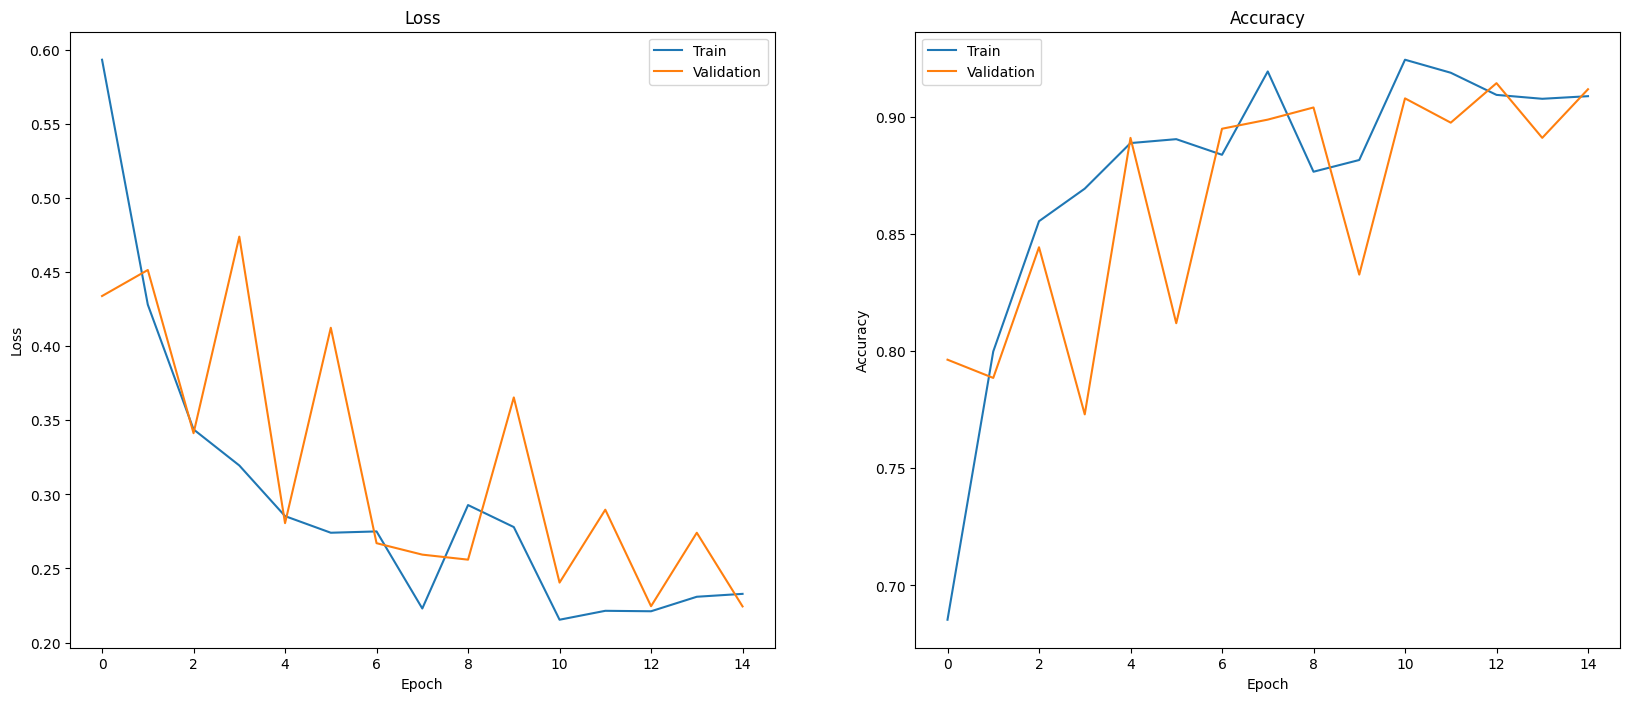

In [87]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(1,2)
  fig.set_size_inches(20, 8)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

In [88]:
y_hat = classifier.predict(x=x_val)
y_hat = np.squeeze(y_hat)
y_hat = (y_hat > 0.5).astype(int)

print("Accuracy:", skmetrics.accuracy_score(y_val, y_hat))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Accuracy: 0.9118028534370947


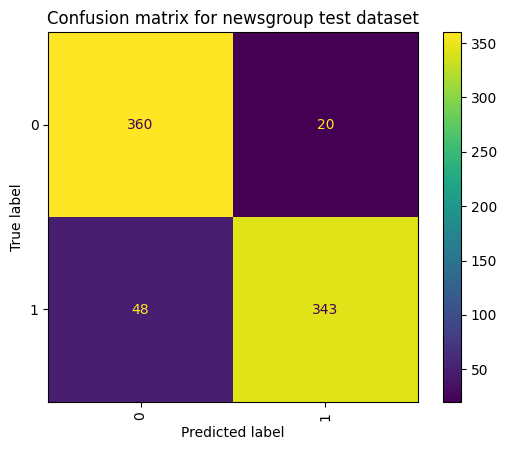

In [89]:
cm = skmetrics.confusion_matrix(y_val, y_hat)
disp = skmetrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1])
disp.plot(xticks_rotation='vertical')
plt.title('Confusion matrix for newsgroup test dataset');
plt.grid(False)